In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Data Parsing 
using urllib.request and beautifulsoup

In [2]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
# % python3 -m pip install bs4

#the url is https://finviz.com/quote.ashx?t=AMZN * * *  ,  t = [ticker]
#we only need https://finviz.com/quote.ashx?t=  and we can add the ticker to the url

finviz_url = "https://finviz.com/quote.ashx?t="
tickers = ['NVDA', 'MSFT','AMZN'	,'META','GOOGL', 'TSLA']


#iterate over tickers and create finziv url to parse

for ticker in tickers:
    url = finviz_url + ticker
    
    #now request data from the url

    req = Request(url = url, headers = {"user-agent":"app"})  #if user agent not specified, forbidden from accessing data
                                                              #https://docs.python.org/3/library/urllib.request.html
                                                              #https://www.geeksforgeeks.org/python/python-urllib-module/
    response = urlopen(req)
    print(response)

    #actual html data
    html = BeautifulSoup(response,'html')

    #data snippet
    #print(str(html)[:5000])
    
    



# Data Manipulation
Parsing and manipulating the html data

In [3]:
news_tables = {}    #store the html page for each ticker in a dictionary
for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url = url, headers = {"user-agent":"app"})  #if user agent not specified, forbidden from accessing data
    response = urlopen(req)
    print(response)


    html = BeautifulSoup(response,'html')

    news_table = html.find(id="news-table")   #find the headlines table

    #dictionary
    news_tables[ticker] = news_table
    


parsed_data = []

for ticker,news_table in news_tables.items():  #iterate through the html pages
    for row in news_table.find_all('tr'):      #find the table row
        if row.a is not None:
            title = row.a.text
            timestamp = row.td.text.split()
            if len(timestamp)==1:
                time = timestamp[0]
            else:
                date = timestamp[0].lower()
                time = timestamp[1]
            parsed_data.append([ticker,date,time,title])   #finally append the data into a list
for i in parsed_data[:10]:
    print(i)

['NVDA', 'today', '02:52PM', "Stock Market Today: Dow Rises, Powell Sees No 'Risk-Free Path' After Rate Cut; Palantir Jumps (Live Coverage)"]
['NVDA', 'today', '02:50PM', 'Nvidia Stock Falters Amid Rival Chips Threat; Is Nvidia A Buy Or Sell Now?']
['NVDA', 'today', '02:49PM', "Buying Stocks on the Cheap Can Cost You More. Here's a Better Strategy."]
['NVDA', 'today', '02:35PM', 'President Donald Trump Just Delivered Incredible News for Nvidia Investors']
['NVDA', 'today', '02:27PM', 'Squawk Pod: AI commission in the House, reaction to chip sales in the GOP - 12/10/25  Audio Only']
['NVDA', 'today', '02:14PM', 'Stock Market Today: Dow Rises As Fed Cuts Rates, Powell Up Next; Palantir Jumps (Live Coverage)']
['NVDA', 'today', '01:47PM', 'Jim Cramer issues blunt 5-word verdict on Nvidia stock']
['NVDA', 'today', '01:35PM', 'These Are The 5 Best Stocks To Buy Now Or Watch']
['NVDA', 'today', '01:33PM', 'Trump says Nvidia can sell H200 chips to China, but nothing is guaranteed']
['NVDA', '

# Applying Sentiment Analysis
using NLTK VADER

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
# % python3 -m pip install nltk

df = pd.DataFrame(parsed_data, columns = ["ticker","date","time","title"])
print(df.head())

vader = SentimentIntensityAnalyzer()  

print(vader.polarity_scores("I hate apple and I think they will do poorly this quarter")) 
#neg neu pos compound

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)    #applies a lambda function to title column

df.head()

  ticker   date     time                                              title
0   NVDA  today  02:52PM  Stock Market Today: Dow Rises, Powell Sees No ...
1   NVDA  today  02:50PM  Nvidia Stock Falters Amid Rival Chips Threat; ...
2   NVDA  today  02:49PM  Buying Stocks on the Cheap Can Cost You More. ...
3   NVDA  today  02:35PM  President Donald Trump Just Delivered Incredib...
4   NVDA  today  02:27PM  Squawk Pod: AI commission in the House, reacti...
{'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'compound': -0.5719}


,ticker,date,time,title,compound
0,NVDA,today,02:52PM,"Stock Market Today: Dow Rises, Powell Sees No ...",-0.5106
1,NVDA,today,02:50PM,Nvidia Stock Falters Amid Rival Chips Threat; ...,-0.5267
2,NVDA,today,02:49PM,Buying Stocks on the Cheap Can Cost You More. ...,0.4902
3,NVDA,today,02:35PM,President Donald Trump Just Delivered Incredib...,0.0000
4,NVDA,today,02:27PM,"Squawk Pod: AI commission in the House, reacti...",0.0000


# Visualization of Data
using matplotlib

/tmp/ipykernel_13/2779287322.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1500x1500 with 0 Axes>

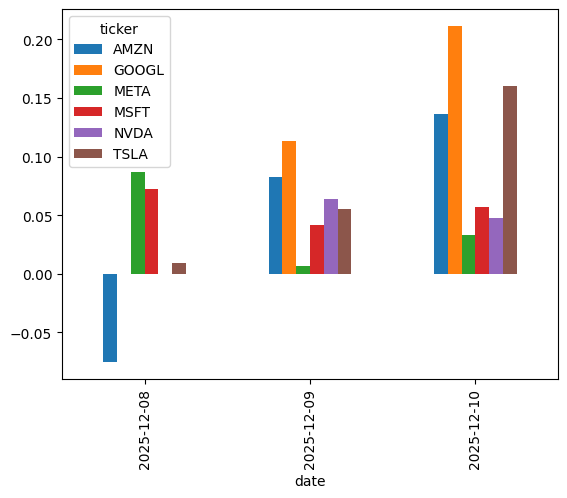

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

# ensure compound is numeric
df['compound'] = pd.to_numeric(df['compound'], errors='coerce')

# ensure date is a proper date
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date

# compute mean sentiment per ticker per date
mean_df = df.groupby(['ticker','date'])['compound'].mean()
mean_df = mean_df.unstack()
mean_df = mean_df.transpose()
mean_df.plot(kind="bar")
plt.show
